In [7]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [8]:
#load data
DroneData = pd.read_csv('./IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')

In [9]:
def extract_normalized_imu_data(DroneData, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData

def find_theta_score(Data):
    """
    Converts n dimensions to a single 1D score,
    for easier visualization
    """
    pca = PCA(n_components=1)
    pca.fit(Data)
    theta_score = pca.transform(Data)
    return theta_score

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    plt.figure(figsize=(14,8))
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)
    

In [10]:
#preprocess

normImuData = extract_normalized_imu_data(DroneData)
trainData = normImuData[:200]
testData = normImuData[200:]
z_score = find_theta_score(testData)

/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


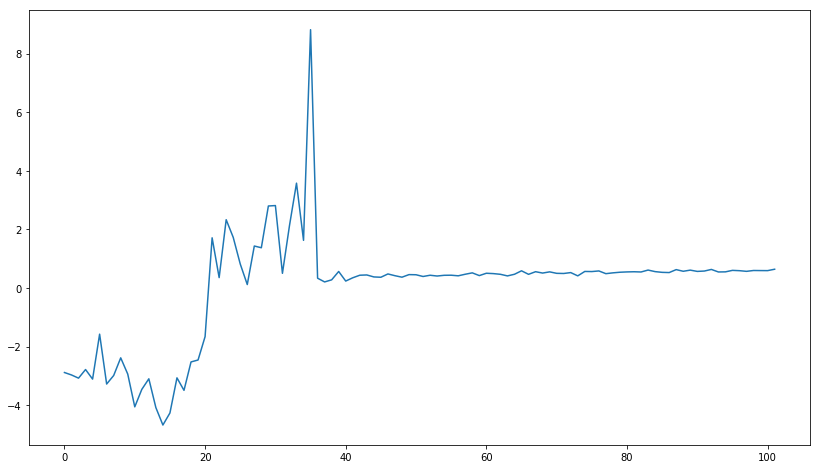

In [11]:
#using IsoFo

#add your algos in this very format pls

from sklearn.ensemble import IsolationForest

#fit isofo model
clf = IsolationForest(n_estimators=100,contamination=0) #contamination parameter specifies the level of contamination in training data
clf.fit(trainData)

#predict anomalies
tempanomalyPrediction = clf.predict(testData)
anomalyPrediction = tempanomalyPrediction == -1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature

plot_anomalies_in_1D(z_score, anomalyPrediction)

/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


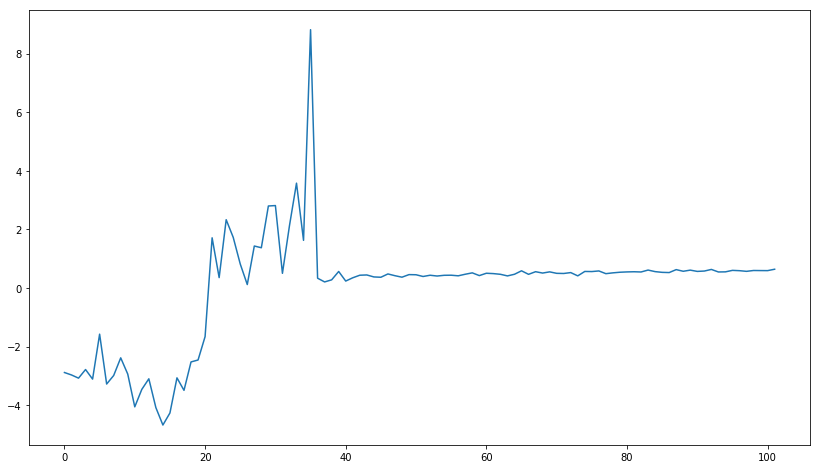

In [12]:
#using one class SVM

from sklearn.svm import OneClassSVM

#fit model
oneclass = OneClassSVM()
oneclass.fit(trainData)

#predict anomalies
tempanomalyPredictionSVM = oneclass.predict(testData)
anomalyPredictionSVM = tempanomalyPrediction == -1

plot_anomalies_in_1D(z_score, anomalyPredictionSVM)